# Continuation Report
Analysis of model continuation behavior at cadence points in Bach chorales.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from pathlib import Path
from collections import Counter

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)

In [2]:
# ---------- Parse data into DataFrame ----------

# Resolve experiment dir regardless of kernel working directory
_candidates = [
    Path("20260129_122947_minorized_cadences"),
    Path("experiments/20260129_122947_minorized_cadences"),
]
EXPERIMENT_DIR = None
for _p in _candidates:
    if _p.is_dir():
        EXPERIMENT_DIR = _p
        break
if EXPERIMENT_DIR is None:
    raise FileNotFoundError(
        "Could not find experiment dir '20260129_122947_minorized_cadences'. "
        "Run this notebook from the experiments/ or repo root directory."
    )
print(f"Using experiment dir: {EXPERIMENT_DIR}")

# ---- Roman numeral roots, longest first, case-sensitive ----
_ROOTS = ["VII", "vii", "III", "iii", "VI", "vi", "IV", "iv", "II", "ii", "V", "v", "I", "i"]


def roman_to_function_group(rn: str) -> str:
    """Map a roman numeral string to a bucket based on accidentals + root degree + case.

    Examples:
        I, I6, I64, Ib753    → I
        i5, i+#54             → i
        vi, vi6, vi7, viø65b3 → vi
        VI, VI6, VI#3         → VI
        bii+#54, bii+#5#2    → bii
        bVI, bVI+5#3          → bVI
        #ivo63b3, #ivo5b3     → #iv
    """
    s = rn.strip()
    # 1. consume leading accidentals (b, #)
    i = 0
    while i < len(s) and s[i] in ("#", "b"):
        i += 1
    accidentals = s[:i]
    rest = s[i:]

    # 2. match root (case-sensitive, longest first)
    for root in _ROOTS:
        if rest.startswith(root):
            return accidentals + root
    return "other"


# Regex for the continuation block entries
cut_re = re.compile(r"---\s*cut_tick_(\d+)\s*\((.+?)\)\s*---")
dur_re = re.compile(r"Original prompt ends at:\s*(\d+)ms")
entry_re = re.compile(
    r"^\s+(original|minorized)_seed(\d+):\s+(.+?)\s*\|\s*(.+?)\s*$"
)

rows = []
for chords_file in sorted(EXPERIMENT_DIR.glob("chorale_*/chorale_*_chords.txt")):
    chorale = chords_file.parent.name  # e.g. chorale_0000
    text = chords_file.read_text()

    # Only look at the CONTINUATION ANALYSIS block
    marker = "CONTINUATION ANALYSIS"
    idx = text.find(marker)
    if idx == -1:
        continue
    block = text[idx:]

    current_tick = None
    current_cadence = None
    current_dur = None

    for line in block.splitlines():
        m = cut_re.search(line)
        if m:
            current_tick = int(m.group(1))
            current_cadence = m.group(2).strip()
            continue
        m = dur_re.search(line)
        if m:
            current_dur = int(m.group(1))
            continue
        m = entry_re.match(line)
        if m:
            variant = m.group(1)
            seed = int(m.group(2))
            chord_name = m.group(3).strip()
            roman = m.group(4).strip()
            if chord_name == "[no notes found]":
                continue
            rows.append(
                {
                    "chorale": chorale,
                    "cut_tick": current_tick,
                    "cadence_type": current_cadence,
                    "prompt_duration_ms": current_dur,
                    "variant": variant,
                    "seed": seed,
                    "chord_name": chord_name,
                    "roman_numeral": roman,
                }
            )

df = pd.DataFrame(rows)
df["function_group"] = df["roman_numeral"].apply(roman_to_function_group)
print(f"Shape: {df.shape}")
print(f"Unique chorales: {df['chorale'].nunique()}")
print(f"Unique cut points: {df.groupby(['chorale','cut_tick']).ngroups}")
print(f"Unique roman numerals: {df['roman_numeral'].nunique()}")
print(f"Function groups: {sorted(df['function_group'].unique())}")
print()
print(df["function_group"].value_counts())
df.head(10)

Using experiment dir: experiments/20260129_122947_minorized_cadences
Shape: (1060, 9)
Unique chorales: 81
Unique cut points: 178
Unique roman numerals: 47
Function groups: ['#iv', '#vi', 'I', 'II', 'IV', 'V', 'VI', 'bVI', 'bii', 'bv', 'bvi', 'i', 'ii', 'iii', 'v', 'vi']

function_group
I      794
vi     121
IV      41
VI      28
ii      25
bii     15
i        9
II       6
#iv      4
V        4
iii      4
bVI      3
v        2
bvi      2
#vi      1
bv       1
Name: count, dtype: int64


,chorale,cut_tick,cadence_type,prompt_duration_ms,variant,seed,chord_name,roman_numeral,function_group
0,chorale_0000,184,Strong Cadence,23000,original,42,Major Third with octave doublings above Bb,I,I
1,chorale_0000,184,Strong Cadence,23000,original,43,Major Third with octave doublings above Bb,I,I
2,chorale_0000,184,Strong Cadence,23000,original,44,Bb-major triad,I,I
3,chorale_0000,184,Strong Cadence,23000,minorized,42,Bb-major triad,I,I
4,chorale_0000,184,Strong Cadence,23000,minorized,43,Major Third with octave doublings above Bb,I,I
5,chorale_0000,184,Strong Cadence,23000,minorized,44,Bb-major triad,I,I
6,chorale_0000,56,Strong Cadence,7000,original,42,Bb-major triad,I,I
7,chorale_0000,56,Strong Cadence,7000,original,43,Perfect Fifth with octave doublings above Bb,i5,i
8,chorale_0000,56,Strong Cadence,7000,original,44,Perfect Fifth with octave doublings above Bb,i5,i
9,chorale_0000,56,Strong Cadence,7000,minorized,42,G-major triad,VI,VI


In [5]:
df['roman_numeral'].unique() 
# adisi todo - i am not sure that the partition to function groups from the roman numerals makes sense - but those are just first results

array(['I', 'i5', 'VI', 'vi', 'vi6', 'IV64', 'IV6', 'ii64', 'ii', 'I6',
       'IV', '#ivo5b3', 'V42', 'ii6', 'bii+#54', 'v5', 'vi7', 'VI7#3',
       'VI6', 'Ib753', 'bVI+#8#5#3', 'bii+#5#2', 'bvi+#5#2', 'bVI',
       '#vio6b5b3', 'iii7', 'IV65', 'vi5', 'viø65b3', 'II', 'ii54',
       '#ivo63b3', 'II75#3', 'IV7', 'iii542', 'bv+#54', 'V', 'bii+4',
       'I64', 'IV763', 'iii', 'iiiob62', 'VI#3', 'IV+6', 'i+#54',
       'bVI+5#3', 'v'], dtype=object)

=== Value counts: variant ===
variant
original     530
minorized    530
Name: count, dtype: int64

=== Value counts: cadence_type ===
cadence_type
Strong Cadence    1060
Name: count, dtype: int64

Display order: ['I', 'i', 'II', 'ii', 'iii', 'IV', 'V', 'v', 'VI', 'vi', '#iv', '#vi', 'bVI', 'bii', 'bv', 'bvi']


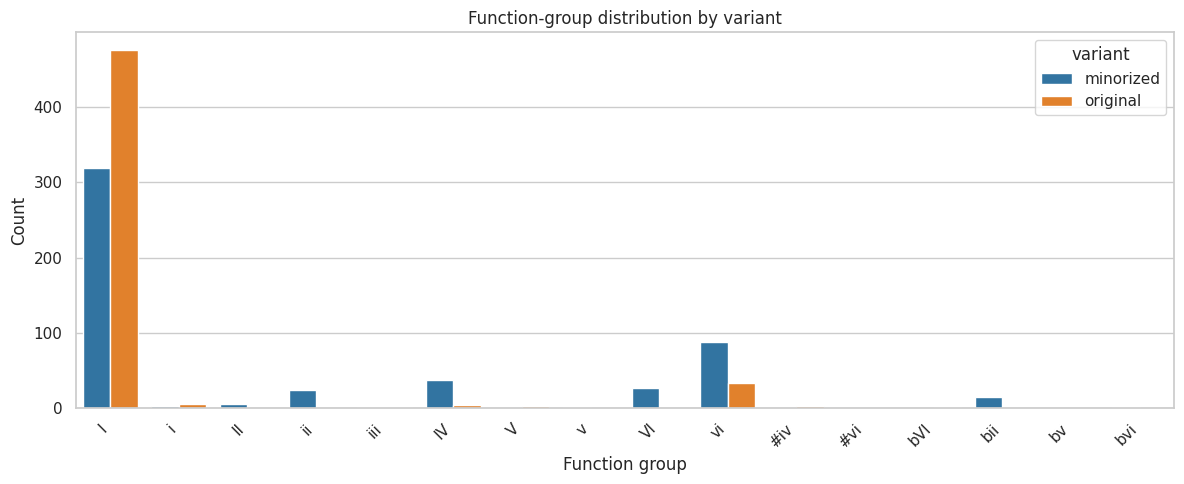

In [6]:
# ---------- Cell 3: Overview ----------

print("=== Value counts: variant ===")
print(df["variant"].value_counts())
print()
print("=== Value counts: cadence_type ===")
print(df["cadence_type"].value_counts())

# Build a display order: diatonic roots by scale degree, then chromatic, then other
_DIATONIC_ORDER = ["I", "i", "II", "ii", "III", "iii", "IV", "iv", "V", "v", "VI", "vi", "VII", "vii"]
_all_groups = df["function_group"].unique()
order = [g for g in _DIATONIC_ORDER if g in _all_groups]
chromatic = sorted(g for g in _all_groups if g not in _DIATONIC_ORDER and g != "other")
order += chromatic
if "other" in _all_groups:
    order.append("other")
print(f"\nDisplay order: {order}")

# Consistent colour mapping: minorized=blue, original=orange
_VARIANT_HUE_ORDER = ["minorized", "original"]
_VARIANT_COLORS = ["tab:blue", "tab:orange"]  # matches hue_order

# Bar chart: function_group coloured by variant
fig, ax = plt.subplots(figsize=(12, 5))
sns.countplot(data=df, x="function_group", hue="variant", order=order,
              hue_order=_VARIANT_HUE_ORDER, palette=_VARIANT_COLORS, ax=ax)
ax.set_title("Function-group distribution by variant")
ax.set_xlabel("Function group")
ax.set_ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

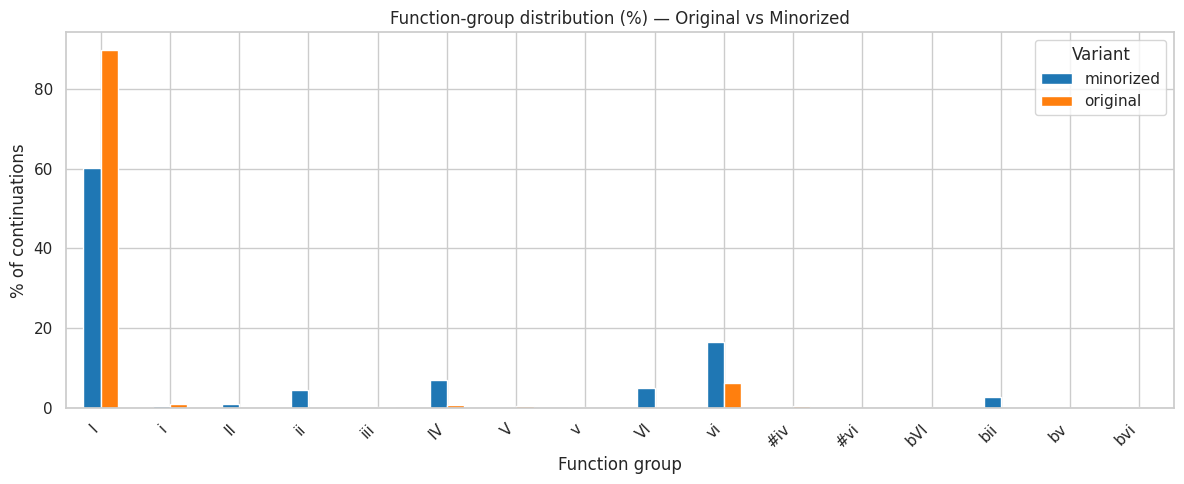

In [7]:
# ---------- Cell 4: Original vs Minorized comparison ----------

# Normalized percentages — reorder columns so minorized is first (blue), original second (orange)
ct = pd.crosstab(df["function_group"], df["variant"], normalize="columns") * 100
ct = ct.reindex(order).fillna(0)
ct = ct[["minorized", "original"]]  # enforce column order

fig, ax = plt.subplots(figsize=(12, 5))
ct.plot.bar(ax=ax, color=_VARIANT_COLORS)
ax.set_title("Function-group distribution (%) — Original vs Minorized")
ax.set_ylabel("% of continuations")
ax.set_xlabel("Function group")
ax.legend(title="Variant")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



the prompt duration quartiles are: 
for Q1 the duration is between 1500.0% and 8000.0% ms 
 for Q2 the duration is between 8000.0% and 18000.0% ms 
 for Q3 the duration is between 18000.0% and 27500.0% ms 
 (for Q4 the duration is between 27500.0% and 62500.0% ms)


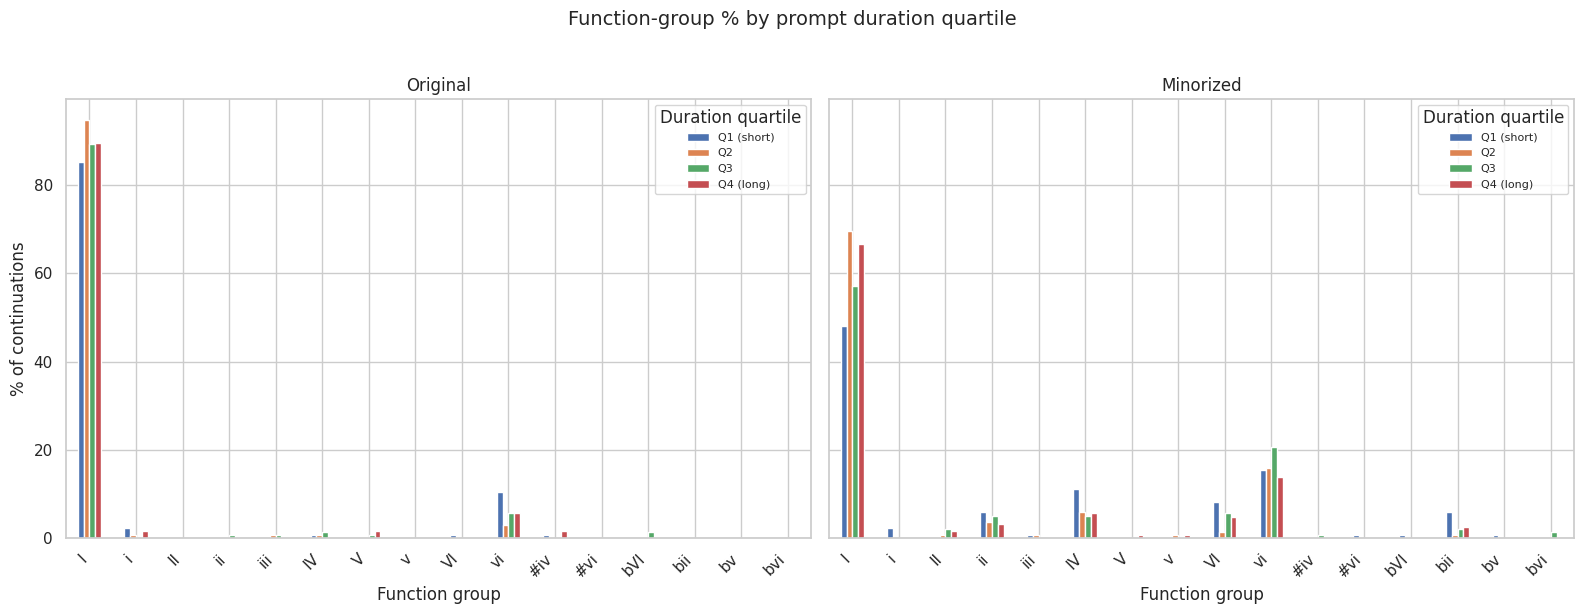

I-resolution rate by duration quartile:
  original: {'Q1 (short)': 85.18518518518519, 'Q2': 94.6969696969697, 'Q3': 89.28571428571429, 'Q4 (long)': 89.43089430894308}
  minorized: {'Q1 (short)': 48.148148148148145, 'Q2': 69.6969696969697, 'Q3': 57.14285714285714, 'Q4 (long)': 66.66666666666666}


In [13]:
# ---------- Cell 5: Prompt length effect ----------

df["duration_quartile"] = pd.qcut(
    df["prompt_duration_ms"], q=4, labels=["Q1 (short)", "Q2", "Q3", "Q4 (long)"]
)

print(f"the prompt duration quartiles are: \n\
for Q1 the duration is between {df['prompt_duration_ms'].quantile(0)}% and {df['prompt_duration_ms'].quantile(0.25)}% ms \n \
for Q2 the duration is between {df['prompt_duration_ms'].quantile(0.25)}% and {df['prompt_duration_ms'].quantile(0.5)}% ms \n \
for Q3 the duration is between {df['prompt_duration_ms'].quantile(0.5)}% and {df['prompt_duration_ms'].quantile(0.75)}% ms \n \
(for Q4 the duration is between {df['prompt_duration_ms'].quantile(0.75)}% and {df['prompt_duration_ms'].quantile(1)}% ms)")

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
for ax, variant in zip(axes, ["original", "minorized"]):
    sub = df[df["variant"] == variant]
    ct = pd.crosstab(sub["function_group"], sub["duration_quartile"], normalize="columns") * 100
    ct = ct.reindex(order).fillna(0)
    ct.plot.bar(ax=ax)
    ax.set_title(f"{variant.title()}")
    ax.set_ylabel("% of continuations")
    ax.set_xlabel("Function group")
    ax.legend(title="Duration quartile", fontsize=8)
    ax.tick_params(axis="x", rotation=45)
    for label in ax.get_xticklabels():
        label.set_ha("right")

fig.suptitle("Function-group % by prompt duration quartile", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# I-rate by quartile
print("I-resolution rate by duration quartile:")
for v in ["original", "minorized"]:
    sub = df[df["variant"] == v]
    rates = sub.groupby("duration_quartile", observed=False)["function_group"].apply(
        lambda s: (s == "I").mean() * 100
    )
    print(f"  {v}: {rates.to_dict()}")

Seed agreement rate (all 3 seeds same function group):
  minorized: 50.6%
  original: 82.0%


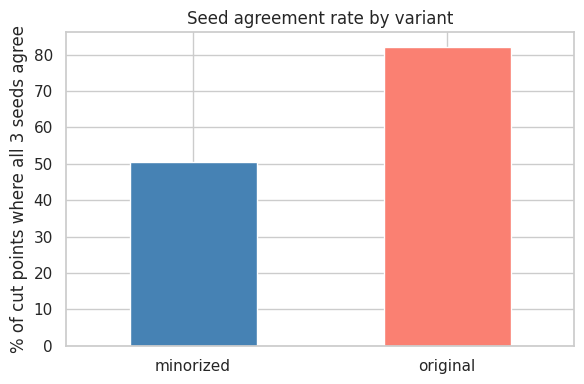

In [16]:
# ---------- Cell 6: Seed consistency ----------

def seed_agreement(group):
    """Return True if all seeds in the group agree on function_group."""
    return group["function_group"].nunique() == 1

consistency = (
    df.groupby(["chorale", "cut_tick", "variant"])["function_group"]
    .apply(lambda g: g.nunique() == 1)
    .reset_index(name="all_agree")
)

rates = consistency.groupby("variant")["all_agree"].mean() * 100
print("Seed agreement rate (all 3 seeds same function group):")
for v, r in rates.items():
    print(f"  {v}: {r:.1f}%")

fig, ax = plt.subplots(figsize=(6, 4))
rates.plot.bar(ax=ax, color=["steelblue", "salmon"])
ax.set_title("Seed agreement rate by variant")
ax.set_ylabel("% of cut points where all 3 seeds agree")
ax.set_xlabel("")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [7]:
# ---------- Cell 7: Detailed crosstab ----------

def summarize_cut(group):
    """Summarize the 6 results for one cut point."""
    parts = []
    for _, row in group.sort_values(["variant", "seed"]).iterrows():
        tag = f"{row['variant'][0]}{row['seed']}"  # e.g. o42, m43
        parts.append(f"{tag}:{row['function_group']}")
    return " ".join(parts)

pivot = (
    df.groupby(["chorale", "cut_tick"])["function_group"]
    .apply(lambda g: summarize_cut(df.loc[g.index]))
    .reset_index(name="results")
)
pivot = pivot.sort_values(["chorale", "cut_tick"])

print(f"Total cut points: {len(pivot)}")
print()
# Show first 20 rows
with pd.option_context("display.max_colwidth", 80, "display.max_rows", 20):
    display(pivot.head(20))

Total cut points: 178



,chorale,cut_tick,results
0,chorale_0000,56,m42:VI m43:i m44:VI o42:I o43:i o44:i
1,chorale_0000,184,m42:I m43:I m44:I o42:I o43:I o44:I
2,chorale_0001,36,m42:vi m43:IV m44:vi o42:I o43:I o44:I
3,chorale_0001,84,m42:ii m43:ii m44:ii o42:IV o43:i o44:I
4,chorale_0001,220,m42:vi m43:vi m44:vi o42:I o43:I o44:I
5,chorale_0002,96,m42:vi m43:vi m44:vi o42:I o43:I o44:I
6,chorale_0002,200,m42:I m43:I m44:I o42:I o43:I o44:I
7,chorale_0003,60,m42:I m43:IV m44:IV o42:vi o43:#iv o44:VI
8,chorale_0003,96,m42:I m43:VI m44:I o42:I o43:I o44:I
9,chorale_0003,168,m42:I o42:I
